In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [148]:
mta_data = pd.read_csv('data/MTA_Bridges___Tunnels_Hourly_Traffic_Rates__Beginning_2010_20241012.csv', thousands=',',
                       dtype={
                        'Plaza ID': int,
                        'Hour': int,
                        'Direction': str,
                        '# Vehicles - E-ZPass': int,
                        '# Vehicles - VToll': int
                       }, parse_dates=['Date'])
mta_data['Total Vehicles'] = mta_data['# Vehicles - E-ZPass'] + mta_data['# Vehicles - VToll']

plaza_ids = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
mta_data = mta_data[mta_data['Plaza ID'].isin(plaza_ids)]

In [162]:
mta_data['Date'].dt.isocalendar().week

0          40
1          40
2          40
3          40
4          40
           ..
1052366    35
1052367    35
1052368    35
1052369    35
1052370    35
Name: week, Length: 1050355, dtype: UInt32

In [153]:
pd.date_range(start="2017-09-03", end="2024-10-05").difference(mta_data['Date'])

DatetimeIndex(['2017-09-24', '2017-09-25', '2017-09-26', '2017-09-27',
               '2017-09-28', '2017-09-29', '2017-09-30', '2017-10-01',
               '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05',
               '2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09',
               '2017-10-10', '2017-10-11', '2017-10-12', '2017-10-13',
               '2017-10-14', '2017-10-15', '2017-10-16', '2017-10-17',
               '2017-10-18', '2017-10-19', '2017-10-20', '2017-10-21',
               '2017-10-29', '2017-10-30', '2017-10-31', '2017-11-01',
               '2017-11-02', '2017-11-03', '2017-11-04', '2017-11-05',
               '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09',
               '2017-11-10', '2017-11-11', '2017-12-10', '2017-12-11',
               '2017-12-12', '2017-12-13', '2017-12-14', '2017-12-15',
               '2017-12-16', '2018-07-01', '2018-08-05', '2018-08-06',
               '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10',
      

There are no missing dates in the dataset. There are missing hours, so we will need to deal with that.

In [121]:
groupby_date = mta_data.groupby('Date').count()

In [173]:
# since we are missing hours in some parts, using a dictionary would be the safest option
data_dict = dict()
# keys are ((plaza_id, day of week), (week number, year))
for date in tqdm(pd.date_range(start="2017-09-03", end="2024-10-05")):
    pydatetime = date.to_pydatetime()
    week_number = pydatetime.isocalendar().week
    year = pydatetime.isocalendar().year
    weekday = pydatetime.isocalendar().weekday
    
    data_slice = mta_data[mta_data['Date'] == date]
    
    for plaza_id in plaza_ids:
        if data_slice.empty:
            data_dict[((plaza_id, weekday), (week_number, year))] = None
            continue
        key = ((plaza_id, weekday), (week_number, year))
        data_dict[key] = data_slice[data_slice['Plaza ID'] == plaza_id]['Total Vehicles']

100%|██████████| 2590/2590 [00:05<00:00, 497.91it/s]


In [177]:
count = 0
for v in data_dict.values():
    if v is None:
        count += 1
print(f'Mising Value: {count}, Percent Missing: {count / len(data_dict) * 100}%')

Mising Value: 960, Percent Missing: 3.7065637065637063%


In [122]:
groupby_date[groupby_date < 24].dropna()

,Hour
Date,
2018-03-11,23.0
2019-03-10,23.0
2020-03-08,23.0
2020-04-22,23.0
2021-03-14,23.0
2022-03-13,23.0
2023-03-12,23.0
2024-03-10,23.0
2024-08-13,20.0


<Axes: xlabel='Hour'>

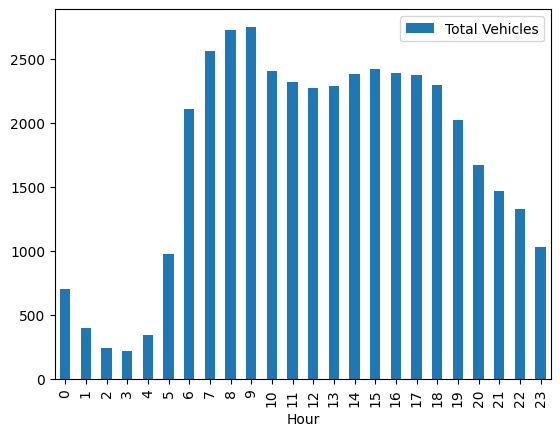

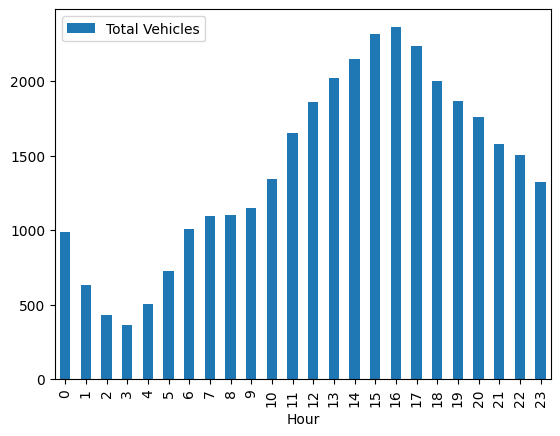

In [123]:
inbound = mta_data_queens_midtown_tunnel[mta_data_queens_midtown_tunnel['Direction'] == 'I']
outbound = mta_data_queens_midtown_tunnel[mta_data_queens_midtown_tunnel['Direction'] == 'O']

total_vehicles_in = inbound['# Vehicles - E-ZPass'] + inbound['# Vehicles - VToll']
inbound['Total Vehicles'] = total_vehicles_in

total_vehicles_out = outbound['# Vehicles - E-ZPass'] + outbound['# Vehicles - VToll']
outbound['Total Vehicles'] = total_vehicles_out

cols = ['Hour', 'Total Vehicles']

inbound = inbound[cols]
inbound.groupby('Hour').mean().plot(kind='bar')

outbound = outbound[cols]
outbound.groupby('Hour').mean().plot(kind='bar')

<Axes: xlabel='Hour'>

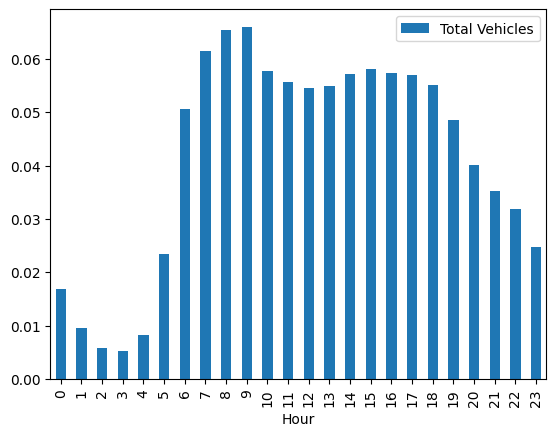

In [124]:
# We don't want to lose the time series information
# Essentially, we are doing functional matrix completion as opposed to distributional.
# There should not really be much of a difference if we also impute the total number of cars in a matrix cell.

# Let's analyze the wasserstein barycenter between two discrete distributions

inbound_mean = inbound.groupby('Hour').mean()

inbound_mean_scaled = inbound_mean / inbound_mean.sum()
inbound_mean_scaled.plot(kind='bar')

<Axes: xlabel='Hour'>

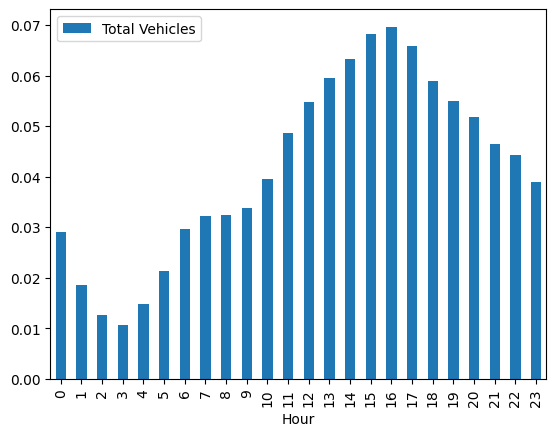

In [125]:
outbound_mean = outbound.groupby('Hour').mean()

outbound_mean_scaled = outbound_mean / outbound_mean.sum()
outbound_mean_scaled.plot(kind='bar')

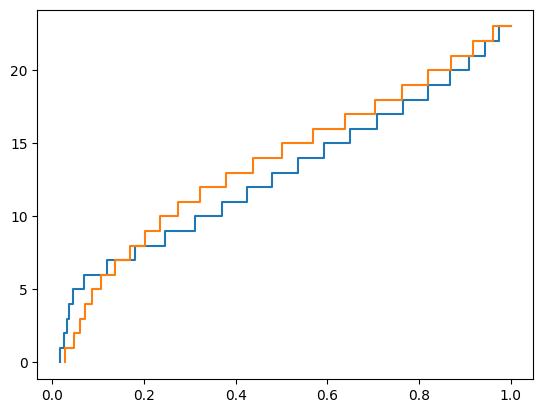

In [126]:
inbound_mean_scaled_cumsum = inbound_mean_scaled.cumsum()
outbound_mean_scaled_cumsum = outbound_mean_scaled.cumsum()

plt.step(inbound_mean_scaled_cumsum,inbound_mean_scaled_cumsum.index)
plt.step(outbound_mean_scaled_cumsum,outbound_mean_scaled_cumsum.index)

In [127]:
def discrete_quantile(values, cdf, q):
    # Find the smallest value where the CDF is greater than or equal to the quantile q
    quantile_value = values[np.searchsorted(cdf, q)]
    
    return quantile_value

In [128]:
values = inbound_mean_scaled.index.to_numpy()
cdf = inbound_mean_scaled_cumsum.values.flatten()

In [129]:
from scipy.integrate import quad
from functools import partial
from numpy import quantile

import warnings
warnings.filterwarnings("ignore")

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

In [130]:
ppf1 = partial(discrete_quantile, inbound_mean_scaled_cumsum.index.to_numpy(), inbound_mean_scaled_cumsum.values.flatten())
ppf2 = partial(discrete_quantile, outbound_mean_scaled_cumsum.index.to_numpy(), outbound_mean_scaled_cumsum.values.flatten())

wasserstein2(ppf1, ppf2)

1.9632668101896897